In [90]:
import numpy as np
from graspy.simulations import sbm
from joblib import Parallel, delayed
from itertools import product
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns

%matplotlib inline

In [39]:
def generate_data(m=10, n=[5,15], p=0.5, delta=0, seed=None):
    np.random.seed(seed)
    p1 = [[p, p],
          [p, p]]
    p2 = [[p+delta, p],
          [p, p]]
    
    pop1 = []
    pop2 = []
    for i in range(m):
        pop1.append(sbm(n, p1))
        pop2.append(sbm(n, p2))
        
    pop1 = np.stack(pop1)
    pop2 = np.stack(pop2)
    
    return pop1, pop2

In [48]:
def run_exp(m, n, p, delta, seed, reps):
    pval = []
    stat = []
    for _ in range(reps):
        pop1_block_mean = np.zeros((m,2,2), dtype=float)
        pop2_block_mean = np.zeros((m,2,2), dtype=float)
        
        pop1, pop2 = generate_data(m, n, p, delta, seed)
        
        pop1_block_mean[:,0,0] = pop1[:,0:n[0],0:n[0]].mean(axis=(1,2))
        pop2_block_mean[:,0,0] = pop2[:,1:n[0],1:n[0]].mean(axis=(1,2))
        pop1_block_mean[:,1,1] = pop1[:,n[0]:n[1],n[0]:n[1]].mean(axis=(1,2))
        pop2_block_mean[:,1,1] = pop2[:,n[0]:n[1],n[0]:n[1]].mean(axis=(1,2))
        pop1_block_mean[:,0,1] = pop1[:,0:n[0],n[0]:n[1]].mean(axis=(1,2))
        pop2_block_mean[:,0,1] = pop2[:,0:n[0],n[0]:n[1]].mean(axis=(1,2))
        pop1_block_mean[:,1,0] = pop1_block_mean[:,0,1]
        pop2_block_mean[:,1,0] = pop2_block_mean[:,0,1]
        
        statistics, pvalue = ttest_ind(pop1_block_mean, pop2_block_mean, axis=0)
        
        pval.append(pvalue)
        stat.append(statistics)
     
    pval = sum(pval)/len(pval)
    stat = sum(stat)/len(stat)
    
    return [stat, pval]

In [71]:
block_1 = 5 
block_2 = 15
n = [block_1, block_2]
sample_size = np.linspace(10,1000,100,dtype=int)
reps = 100
p = .5
deltas = np.linspace(0, 1 - p, 100)

In [ ]:
args = [(m, n, p, delta, seed*reps, reps) for seed, (m, delta) in enumerate(product(sample_size, deltas))]

res = Parallel(n_jobs=-2, verbose=1)(
    delayed(run_exp)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done 356 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-2)]: Done 706 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 1156 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-2)]: Done 1706 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-2)]: Done 2356 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-2)]: Done 3106 tasks      | elapsed: 41.6min


In [209]:
data = { 'p': [a[2] for a in args], 
         'effect size': [a[3] for a in args], 
         'sample size': [a[0] for a in args], 
         'pval': [a[1][0][0] for a in res], 
         'stat': [a[0][0][0] for a in res] }

In [210]:
res_df = pd.DataFrame(data)
res_df.to_csv('20191217.csv')
res_df.head()

,p,effect size,sample size,pval,stat
0,0.5,0.000000,10,0.272052,1.133071
1,0.5,0.005051,10,0.180775,-1.392369
2,0.5,0.010101,10,0.600772,0.532677
3,0.5,0.015152,10,0.824101,-0.225539
4,0.5,0.020202,10,0.033374,2.303743


In [214]:
df1 = pd.pivot_table(res_df,
                    index='sample size',
                    values='pval',
                    columns='effect size')

df2 = pd.pivot_table(res_df,
                    index='sample size',
                    values='stat',
                    columns='effect size')
df2.head()

effect size,0.000000,0.005051,0.010101,0.015152,0.020202,0.025253,0.030303,0.035354,0.040404,0.045455,...,0.454545,0.459596,0.464646,0.469697,0.474747,0.479798,0.484848,0.489899,0.494949,0.500000
sample size,,,,,,,,,,,,,,,,,,,,,
10,1.133071,-1.392369,0.532677,-0.225539,2.303743,1.217195,1.384628,-0.185914,-0.904510,-1.168929,...,-9.855842,-14.272539,-9.806827,-10.000300,-8.071795,-6.595535,-11.092650,-6.602886,-6.263057,-8.507748
20,0.302742,-1.474902,0.518306,0.421797,2.094395,1.526976,-0.843184,-1.196624,-1.558800,0.437619,...,-8.700846,-10.748918,-7.853130,-9.557730,-12.190188,-15.627265,-12.268105,-12.933709,-11.436822,-17.161248
30,0.933446,-0.802526,-0.063769,0.290110,-2.140423,-0.549675,1.925606,-0.316472,1.229617,-1.838333,...,-12.412606,-16.900210,-12.329049,-12.681364,-12.426608,-13.246400,-11.594192,-14.168389,-15.018531,-12.249205
40,0.127656,0.461773,1.624478,1.434285,0.554778,-0.263212,-0.032052,-0.959744,1.463861,0.745750,...,-12.608476,-13.487816,-13.893796,-15.806145,-13.537883,-17.080526,-18.082143,-15.201576,-16.447380,-17.837928
50,2.071884,-1.077587,-0.418624,0.688025,1.867455,0.401066,0.394234,0.669162,-1.001164,0.063995,...,-18.535278,-13.356723,-11.482141,-19.494629,-18.590346,-17.691963,-18.551594,-18.014165,-22.114967,-20.421676


[Text(0.5, 0, '0.00'),
 Text(10.5, 0, '0.05'),
 Text(20.5, 0, '0.10'),
 Text(30.5, 0, '0.15'),
 Text(40.5, 0, '0.20'),
 Text(50.5, 0, '0.25'),
 Text(60.5, 0, '0.30'),
 Text(70.5, 0, '0.35'),
 Text(80.5, 0, '0.40'),
 Text(90.5, 0, '0.45')]

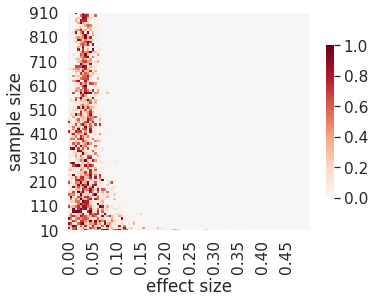

In [213]:
sns.set(font_scale=1.4)
ax = sns.heatmap(
        df,
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels= 10,#[fmt(i) for i in np.linspace(0, 1 - p, 101)[::10]],
        yticklabels=10,
        vmin=0, 
        vmax=1
    )
ax.invert_yaxis()

fmt = '{:0.2f}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
    
ax.set_xticklabels(xticklabels)
#ax.set_yticklabels(yticklabels)


Text(0.5, 1, 'Test statistics')

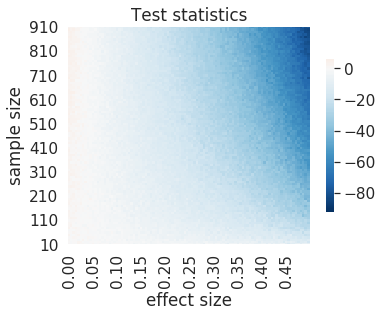

In [217]:
sns.set(font_scale=1.4)
ax = sns.heatmap(
        df2,
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels= 10,#[fmt(i) for i in np.linspace(0, 1 - p, 101)[::10]],
        yticklabels=10
    )
ax.invert_yaxis()

fmt = '{:0.2f}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
    
ax.set_xticklabels(xticklabels)
ax.set_title('Test statistics')
#ax.set_yticklabels(yticklabels)



In [218]:
'{:0.2f}'.format(2.34455)

'2.34'